# CAR-19 Data Analysis

This notebook runs the code in the nircam_calib/comissioning/NRC_19_subarrays module in order to analyze data from CAR-19 (Subarray Verification)

## Table of Contents

* [Goal 1: Register and Combine data in pipeline](#goal_1)
* [Goal 2: Confirm positions of subarrays on detectors](#goal_2)
* [Goal 3: Confirm telescope pointing places target in correct location](#goal_3)
* [Goal 4: Confirm same charge accumulation rate in subarrays vs full frame](#goal_4)
* [Goal 5: Identify and characterize latency effects](#goal_5)

In [1]:
from glob import glob
import os

In [2]:
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
from jwst.pipeline.calwebb_image2 import Image2Pipeline
from jwst.pipeline.calwebb_image3 import Image3Pipeline

In [3]:
from nircam_calib.commissioning.NRC_19_subarrays import confirm_subarray_location_via_sources as locations
from nircam_calib.commissioning.NRC_19_subarrays import confirm_telescope_pointing as pointing
from nircam_calib.commissioning.NRC_19_subarrays import confirm_count_rates as count_rates
from nircam_calib.commissioning.NRC_19_subarrays import latency_investigation as latency

In [ ]:
base_dir = 'path_to_simulationWG_CAR-19_directory'

<a id='goal_1'></a>
## Goal 1: Check that calibration pipeline correctly registers and combines subarray data

 Run pipeline through level3 separately for each aperture
 
 examine output:  
      measure FWHM of sources  
      visual inspection of mosaic size/shape

### Calwebb_detector1

In [ ]:
def run_calwebb_detector1(filename):
    m = Detector1Pipeline(config_file='pipeline_config_files/calwebb_detector1.cfg')

    # make changes to the parameters/reference files used
    m.refpix.odd_even_rows = False

    # jump step is way too sensitive
    m.jump.rejection_threshold = 91

    # skip steps you don't want to run
    m.group_scale.skip = True
    m.ipc.skip = True
    m.rscd.skip = True
    m.firstframe.skip = True
    m.lastframe.skip = True

    # name your output file
    m.save_results = True
    m.output_dir = os.path.join(base_dir, 'Pipeline_Level1/')
    m.output_file = os.path.basename(filename.replace('_uncal', '_rate'))

    # run the pipeline with these paramters
    m.run(filename)
    print('')
    print("Done running CALDETECTOR1 on {}".format(filename))
    print("Output saved to {}".format(os.path.join(m.output_dir, m.output_file)))
    print('')

#### Run calwebb_detector1

In [ ]:
uncal_files = glob(os.path.join(base_dir, 'Mirage_Output/j*uncal.fits'))
for filename in uncal_files:
    run_calwebb_detector1(filename)

### Calwebb_image2

In [ ]:
def make_level2_association(file_list, asn_filename):
    idx = file_list[0].find('nrca1')
    prod_name = file_list[0][0: idx+5]
    asn = asn_from_list(file_list, rule=DMSLevel2bBase, product_name=prod_name)
    outfile = os.path.join(base_dir, 'Pipeline_Level2/', asn_filename)
    with open(outfile, 'w') as fh:
        fh.write(asn.dump()[1])

In [23]:
def run_calwebb_image2(filename, tso=False):
    if not tso:
        result2 = Image2Pipeline(config_file='pipeline_config_files/calwebb_image2.cfg')
    else:
        result2 = Image2Pipeline(config_file='pipeline_config_files/calwebb_tso-image2.cfg')
    result2.save_results = True
    result2.output_dir = os.path.join(base_dir, 'Pipeline_Level2/')
    result2.run(filename)

#### 1. Create association files

Create association files. For level2 it's not as important, but let's make one association file for each subarray size

In [21]:
sub160_asn = 'Pipeline_Level2/level2_sub160_files_asn.json'
sub160_rate_files = glob(os.path.join(base_dir, 'Pipeline_Level1/jw01068001001*rate.fits'))
#make_level2_association(sub160_rate_files, sub160_asn)

sub320_asn = 'Pipeline_Level2/level2_sub320_files_asn.json'
sub320_rate_files = glob(os.path.join(base_dir,'Pipeline_Level1/jw01068002001*rate.fits'))
#make_level2_association(sub320_rate_files, sub320_asn)

sub640_asn = 'Pipeline_Level2/level2_sub640_files_asn.json'
sub640_rate_files = glob(os.path.join(base_dir,'Pipeline_Level1/jw01068003001*rate.fits'))
#make_level2_association(sub640_rate_files, sub640_asn)

full_asn = 'Pipeline_Level2/level2_full_files_asn.json'
full_rate_files = glob(os.path.join(base_dir,'Pipeline_Level1/jw01068004001*rate.fits'))
#make_level2_association(full_rate_files, full_asn)

sub400p_asn = 'Pipeline_Level2/level2_sub400p_files_asn.json'
sub400p_rate_files = glob(os.path.join(base_dir,'Pipeline_Level1/jw01068005001*rate.fits'))
#make_level2_association(sub400p_rate_files, sub400p_asn)

sub64p_asn = 'Pipeline_Level2/level2_sub64p_files_asn.json'
sub64p_rate_files = glob(os.path.join(base_dir,'Pipeline_Level1/jw01068006001*rate.fits'))
#make_level2_association(sub64p_rate_files, sub64p_asn)

substripe256_asn = 'Pipeline_Level2/level2_substrip256_files_asn.json'
substripe256_rate_files = glob(os.path.join(base_dir,'Pipeline_Level1/jw01068007001*rate.fits'))
#make_level2_association(substrip256_rate_files, substrip256_asn)

print('Manually add asn_pool to the level2 association files')

Manually add asn_pool to the level2 association files


#### 2. Run calwebb_image2

In [24]:
#association_files = [sub160_asn, sub320_asn, sub640_asn, full_asn, sub400p_asn, sub64p_asn]
#association_files = [sub640_asn, full_asn, sub400p_asn, sub64p_asn]
association_files = [sub160_asn]
for asn in association_files:
    if asn != substripe256_asn:
        run_calwebb_image2(asn)
    else:
        run_calwebb_image2(asn, tso=True)

2020-03-10 12:28:00,823 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2020-03-10 12:28:00,826 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2020-03-10 12:28:00,831 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2020-03-10 12:28:00,834 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2020-03-10 12:28:00,838 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2020-03-10 12:28:00,843 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2020-03-10 12:28:01,899 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068006001_01101_00001_nrcb1_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:01,905 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b

2020-03-10 12:28:02,059 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068003001_01101_00003_nrcb3_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,067 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068003001_01101_00003_nrcb2_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,069 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068003001_01101_00003_nrcb1_cal.fits' mode='rb' closefd=True>
  gc.collec

2020-03-10 12:28:02,239 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068002001_01101_00001_nrcb2_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,249 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068002001_01101_00001_nrcb1_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,260 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00016_nrcb4_cal.fits' mode='rb' closefd=True>
  gc.collec

2020-03-10 12:28:02,436 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00011_nrcb1_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,445 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00010_nrcb4_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,455 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00010_nrcb3_cal.fits' mode='rb' closefd=True>
  gc.collec

2020-03-10 12:28:02,624 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00004_nrcb4_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,626 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00004_nrcb3_cal.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:02,636 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00004_nrcb2_cal.fits' mode='rb' closefd=True>
  gc.collec

2020-03-10 12:28:05,602 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.486916569 -69.494713069 80.486913900 -69.493340579 80.483014363 -69.493339213 80.483013137 -69.494711275
2020-03-10 12:28:05,603 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.486916569 -69.494713069 80.486913900 -69.493340579 80.483014363 -69.493339213 80.483013137 -69.494711275
2020-03-10 12:28:05,604 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:28:05,619 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:28:05,712 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00015_nrcb3_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:05,727 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field runnin

2020-03-10 12:28:11,631 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:28:11,924 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:28:11,935 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.28975
2020-03-10 12:28:11,964 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:28:12,058 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(160, 160) from jw01068001001_01101_00001_nrcb4_rate.fits>,).
2020-03-10 12:28:12,061 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheade

2020-03-10 12:28:15,141 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:28:15,156 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:28:15,249 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00012_nrcb3_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:15,263 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00012_nrcb3_rate.fits>,).
2020-03-10 12:28:15,266 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, '

2020-03-10 12:28:19,977 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheaders': False}
2020-03-10 12:28:20,015 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:28:20,243 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:28:20,275 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.485000968 -69.496630598 80.485007099 -69.493828865 80.477059177 -69.493826550 80.477052007 -69.496628283
2020-03-10 12:28:20,279 - stpipe.Image2Pi

2020-03-10 12:28:23,193 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00004_nrcb4_rate.fits>,).
2020-03-10 12:28:23,195 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'save_interpolated_flat': False}
2020-03-10 12:28:23,596 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:28:23,628 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:28:23,731 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00004_nrcb4_rate.fits>,).
2020-03-10 12:28:23,735 - stpipe.Image2Pipeline.phot

2020-03-10 12:28:28,609 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:28:28,807 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:28:28,840 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.479625568 -69.497219031 80.479659051 -69.495839160 80.475744284 -69.495827462 80.475710549 -69.497207332
2020-03-10 12:28:28,844 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:28:28,845 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00016_nrcb2
2020-03-10 12:28:28,846 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00016_nrcb5
2020-03-10 12:28:28,848 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00016_nrcb5_rate.fits ...
2020-03-10 12:28:29,202 - stpipe.Image2Pipeline.assign_wcs 

2020-03-10 12:28:32,490 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:28:32,517 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:28:32,620 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00012_nrcb4_rate.fits>,).
2020-03-10 12:28:32,623 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:28:32,662 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0069.fits
2020-03-10 12:28:32,674 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/j

2020-03-10 12:28:35,695 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:28:35,696 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00010_nrcb2
2020-03-10 12:28:35,698 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00005_nrcb5
2020-03-10 12:28:35,699 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00005_nrcb5_rate.fits ...
2020-03-10 12:28:36,131 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00005_nrcb5_rate.fits>,).
2020-03-10 12:28:36,134 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'in

2020-03-10 12:28:39,393 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:28:39,427 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0073.fits
2020-03-10 12:28:39,450 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0029.fits
2020-03-10 12:28:39,570 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:28:39,571 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB2
2020-03-10 12:28:39,572 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:28:39,573 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W

2020-03-10 12:28:42,579 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00013_nrcb2_rate.fits ...
2020-03-10 12:28:42,978 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00013_nrcb2_rate.fits>,).
2020-03-10 12:28:42,982 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-03-10 12:28:43,351 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.479423083 -69.497201365 80.479454568 -69.495826848 80.475550414 -69.495813735 80.475514953 -69.497187834
2020-03-10 12:28:43,352 - stpipe.Image2Pipeline.assign_wcs - I

2020-03-10 12:28:47,215 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0066.fits
2020-03-10 12:28:47,235 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0021.fits
2020-03-10 12:28:47,353 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:28:47,354 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB1
2020-03-10 12:28:47,355 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:28:47,356 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W
2020-03-10 12:28:47,358 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:28:47,611 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:28:47,618 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.56408
2020-03-10 12:28:47,642 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:28:4

2020-03-10 12:28:51,120 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.479108967 -69.494702156 80.479123154 -69.493321903 80.475201804 -69.493314990 80.475183689 -69.494694836
2020-03-10 12:28:51,121 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.479108967 -69.494702156 80.479123154 -69.493321903 80.475201804 -69.493314990 80.475183689 -69.494694836
2020-03-10 12:28:51,122 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:28:51,137 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:28:51,257 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00015_nrcb1_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:51,270 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field runnin

2020-03-10 12:28:54,201 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:28:54,340 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:28:54,345 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.57295
2020-03-10 12:28:54,369 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:28:54,501 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(160, 160) from jw01068001001_01101_00007_nrcb3_rate.fits>,).
2020-03-10 12:28:54,504 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheade

2020-03-10 12:28:57,684 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:28:57,691 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:28:57,810 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00011_nrcb2_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:28:57,825 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00011_nrcb2_rate.fits>,).
2020-03-10 12:28:57,828 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, '

2020-03-10 12:29:01,182 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheaders': False}
2020-03-10 12:29:01,225 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:29:01,446 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:29:01,477 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.498054979 -69.496696630 80.498061110 -69.493894896 80.490113163 -69.493892581 80.490105993 -69.496694315
2020-03-10 12:29:01,481 - stpipe.Image2Pi

2020-03-10 12:29:04,854 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00007_nrcb2_rate.fits>,).
2020-03-10 12:29:04,855 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'save_interpolated_flat': False}
2020-03-10 12:29:05,147 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:29:05,179 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:29:05,316 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00007_nrcb2_rate.fits>,).
2020-03-10 12:29:05,320 - stpipe.Image2Pipeline.phot

2020-03-10 12:29:08,108 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:29:08,292 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (161, 160)
2020-03-10 12:29:08,321 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.492100730 -69.499260175 80.492116817 -69.497874360 80.488184660 -69.497868717 80.488168319 -69.499254531
2020-03-10 12:29:08,326 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:29:08,327 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00007_nrcb1
2020-03-10 12:29:08,329 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00016_nrcb1
2020-03-10 12:29:08,330 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00016_nrcb1_rate.fits ...
2020-03-10 12:29:08,721 - stpipe.Image2Pipeline.assign_wcs 

2020-03-10 12:29:11,886 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:29:11,915 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:29:12,052 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00002_nrcb3_rate.fits>,).
2020-03-10 12:29:12,056 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:29:12,098 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0068.fits
2020-03-10 12:29:12,116 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/j

2020-03-10 12:29:15,140 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:29:15,141 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00012_nrcb1
2020-03-10 12:29:15,142 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00014_nrcb3
2020-03-10 12:29:15,143 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00014_nrcb3_rate.fits ...
2020-03-10 12:29:15,549 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00014_nrcb3_rate.fits>,).
2020-03-10 12:29:15,552 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'in

2020-03-10 12:29:19,160 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:29:19,205 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0068.fits
2020-03-10 12:29:19,225 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0023.fits
2020-03-10 12:29:19,353 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:29:19,354 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB3
2020-03-10 12:29:19,356 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:29:19,356 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W

2020-03-10 12:29:22,249 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00006_nrcb5_rate.fits ...
2020-03-10 12:29:22,652 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00006_nrcb5_rate.fits>,).
2020-03-10 12:29:22,655 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-03-10 12:29:23,032 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.498083583 -69.501216039 80.498082438 -69.498424399 80.490158600 -69.498418998 80.490144211 -69.501209002
2020-03-10 12:29:23,033 - stpipe.Image2Pipeline.assign_wcs - I

2020-03-10 12:29:26,094 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0069.fits
2020-03-10 12:29:26,111 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0020.fits
2020-03-10 12:29:26,230 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:29:26,231 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB4
2020-03-10 12:29:26,232 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:29:26,233 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W
2020-03-10 12:29:26,234 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:29:26,382 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:29:26,388 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.28975
2020-03-10 12:29:26,413 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:29:2

2020-03-10 12:29:29,945 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.498157075 -69.496639402 80.498155928 -69.493847761 80.490233782 -69.493842362 80.490219399 -69.496632365
2020-03-10 12:29:29,946 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.498157075 -69.496639402 80.498155928 -69.493847761 80.490233782 -69.493842362 80.490219399 -69.496632365
2020-03-10 12:29:29,948 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:29:29,959 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:29:30,115 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00012_nrcb5_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:29:30,131 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field runnin

2020-03-10 12:29:33,303 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:29:33,467 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:29:33,472 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.520739
2020-03-10 12:29:33,504 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:29:33,661 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(160, 160) from jw01068001001_01101_00014_nrcb5_rate.fits>,).
2020-03-10 12:29:33,664 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendhead

2020-03-10 12:29:37,083 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:29:37,094 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:29:37,240 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00003_nrcb1_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:29:37,251 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00003_nrcb1_rate.fits>,).
2020-03-10 12:29:37,254 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, '

2020-03-10 12:29:40,751 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheaders': False}
2020-03-10 12:29:40,787 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:29:40,947 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:29:40,977 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.486937562 -69.497175615 80.486939060 -69.495794918 80.483021958 -69.495794353 80.483020207 -69.497175050
2020-03-10 12:29:40,980 - stpipe.Image2Pi

2020-03-10 12:29:44,268 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00009_nrcb3_rate.fits>,).
2020-03-10 12:29:44,271 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'save_interpolated_flat': False}
2020-03-10 12:29:44,635 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:29:44,668 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:29:44,825 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00009_nrcb3_rate.fits>,).
2020-03-10 12:29:44,828 - stpipe.Image2Pipeline.phot

2020-03-10 12:29:47,946 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:29:48,123 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:29:48,151 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.485064225 -69.496692844 80.485070355 -69.493891110 80.477122410 -69.493888795 80.477115240 -69.496690528
2020-03-10 12:29:48,155 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:29:48,156 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00015_nrcb5
2020-03-10 12:29:48,157 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00008_nrcb5
2020-03-10 12:29:48,159 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00008_nrcb5_rate.fits ...
2020-03-10 12:29:48,583 - stpipe.Image2Pipeline.assign_wcs 

2020-03-10 12:29:51,935 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:29:51,963 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:29:52,124 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00001_nrcb3_rate.fits>,).
2020-03-10 12:29:52,128 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:29:52,166 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0068.fits
2020-03-10 12:29:52,190 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/j

2020-03-10 12:29:55,468 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:29:55,469 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00010_nrcb3
2020-03-10 12:29:55,472 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00001_nrcb1
2020-03-10 12:29:55,473 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00001_nrcb1_rate.fits ...
2020-03-10 12:29:55,935 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00001_nrcb1_rate.fits>,).
2020-03-10 12:29:55,938 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'in

2020-03-10 12:29:59,533 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:29:59,571 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0066.fits
2020-03-10 12:29:59,592 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0021.fits
2020-03-10 12:29:59,710 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:29:59,711 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB1
2020-03-10 12:29:59,712 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:29:59,713 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W

2020-03-10 12:30:02,843 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00008_nrcb4_rate.fits ...
2020-03-10 12:30:03,304 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00008_nrcb4_rate.fits>,).
2020-03-10 12:30:03,307 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-03-10 12:30:03,716 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.499906427 -69.501725185 80.499906047 -69.500349879 80.495998588 -69.500347482 80.495994971 -69.501722356
2020-03-10 12:30:03,717 - stpipe.Image2Pipeline.assign_wcs - I

2020-03-10 12:30:07,081 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0066.fits
2020-03-10 12:30:07,098 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0021.fits
2020-03-10 12:30:07,217 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:30:07,218 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB1
2020-03-10 12:30:07,219 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:30:07,220 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W
2020-03-10 12:30:07,221 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:30:07,382 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:30:07,389 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.56408
2020-03-10 12:30:07,420 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:30:0

2020-03-10 12:30:11,096 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.500024804 -69.499218022 80.500022136 -69.497845532 80.496121779 -69.497844166 80.496120551 -69.499216228
2020-03-10 12:30:11,097 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.500024804 -69.499218022 80.500022136 -69.497845532 80.496121779 -69.497844166 80.496120551 -69.499216228
2020-03-10 12:30:11,098 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:30:11,110 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:30:11,295 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00008_nrcb3_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:30:11,315 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field runnin

2020-03-10 12:30:14,692 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:30:14,848 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:30:14,859 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.56408
2020-03-10 12:30:14,890 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:30:15,080 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(160, 160) from jw01068001001_01101_00005_nrcb1_rate.fits>,).
2020-03-10 12:30:15,084 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheade

2020-03-10 12:30:18,891 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:30:18,901 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:30:19,077 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00013_nrcb3_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:30:19,093 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00013_nrcb3_rate.fits>,).
2020-03-10 12:30:19,096 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, '

2020-03-10 12:30:22,709 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheaders': False}
2020-03-10 12:30:22,747 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:30:22,939 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:30:22,971 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.499973560 -69.499248876 80.499972712 -69.497870775 80.496062595 -69.497871027 80.496063192 -69.499249128
2020-03-10 12:30:22,975 - stpipe.Image2Pi

2020-03-10 12:30:26,369 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00004_nrcb3_rate.fits>,).
2020-03-10 12:30:26,372 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'save_interpolated_flat': False}
2020-03-10 12:30:26,759 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:30:26,795 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:30:27,014 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00004_nrcb3_rate.fits>,).
2020-03-10 12:30:27,017 - stpipe.Image2Pipeline.phot

2020-03-10 12:30:30,306 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:30:30,512 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:30:30,543 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.491554230 -69.498969752 80.491560363 -69.496168019 80.483611573 -69.496165703 80.483604401 -69.498967437
2020-03-10 12:30:30,549 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:30:30,550 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00003_nrcb5
2020-03-10 12:30:30,551 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00005_nrcb4
2020-03-10 12:30:30,552 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00005_nrcb4_rate.fits ...
2020-03-10 12:30:31,013 - stpipe.Image2Pipeline.assign_wcs 

2020-03-10 12:30:34,632 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:30:34,664 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:30:34,866 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00005_nrcb2_rate.fits>,).
2020-03-10 12:30:34,869 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:30:34,908 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0073.fits
2020-03-10 12:30:34,924 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/j

2020-03-10 12:30:38,321 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:30:38,322 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00009_nrcb4
2020-03-10 12:30:38,324 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00014_nrcb2
2020-03-10 12:30:38,325 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00014_nrcb2_rate.fits ...
2020-03-10 12:30:38,844 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00014_nrcb2_rate.fits>,).
2020-03-10 12:30:38,847 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'in

2020-03-10 12:30:42,625 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:30:42,676 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0069.fits
2020-03-10 12:30:42,696 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0020.fits
2020-03-10 12:30:42,838 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:30:42,839 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB4
2020-03-10 12:30:42,839 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:30:42,840 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W

2020-03-10 12:30:46,358 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00008_nrcb1_rate.fits ...
2020-03-10 12:30:46,896 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00008_nrcb1_rate.fits>,).
2020-03-10 12:30:46,900 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-03-10 12:30:47,301 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.492215561 -69.499207105 80.492229751 -69.497826852 80.488307577 -69.497819939 80.488289457 -69.499199784
2020-03-10 12:30:47,302 - stpipe.Image2Pipeline.assign_wcs - I

2020-03-10 12:30:51,063 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0073.fits
2020-03-10 12:30:51,081 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0029.fits
2020-03-10 12:30:51,218 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2020-03-10 12:30:51,219 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCB2
2020-03-10 12:30:51,220 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2020-03-10 12:30:51,222 - stpipe.Image2Pipeline.photom - INFO -  filter: F200W
2020-03-10 12:30:51,223 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:30:51,387 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:30:51,392 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.5276
2020-03-10 12:30:51,426 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:30:51

2020-03-10 12:30:55,724 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  80.486734966 -69.497157986 80.486734585 -69.495782681 80.482827959 -69.495780284 80.482824344 -69.497155158
2020-03-10 12:30:55,726 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.486734966 -69.497157986 80.486734585 -69.495782681 80.482827959 -69.495780284 80.482824344 -69.497155158
2020-03-10 12:30:55,727 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:30:55,740 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:30:55,962 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00013_nrcb4_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:30:55,978 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field runnin

2020-03-10 12:30:59,710 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2020-03-10 12:30:59,888 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2020-03-10 12:30:59,899 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.56408
2020-03-10 12:30:59,931 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-03-10 12:31:00,173 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(160, 160) from jw01068001001_01101_00002_nrcb1_rate.fits>,).
2020-03-10 12:31:00,176 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheade

2020-03-10 12:31:04,482 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-03-10 12:31:04,493 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-03-10 12:31:04,703 - stpipe.Image2Pipeline - WARNING - /Users/hilbert/miniconda3/envs/jwst_b7.4/lib/python3.7/site-packages/jwst/stpipe/step.py:343: ResourceWarning: unclosed file <_io.FileIO name='Pipeline_Level1/jw01068001001_01101_00006_nrcb2_rate.fits' mode='rb' closefd=True>
  gc.collect()

2020-03-10 12:31:04,718 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00006_nrcb2_rate.fits>,).
2020-03-10 12:31:04,721 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, '

2020-03-10 12:31:08,689 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'resample', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'pixfrac': None, 'kernel': None, 'fillval': None, 'weight_type': None, 'good_bits': 6, 'single': False, 'blendheaders': False}
2020-03-10 12:31:08,740 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:31:08,939 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:31:08,969 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.485924683 -69.499482535 80.485958170 -69.498102663 80.482042990 -69.498090965 80.482009250 -69.499470836
2020-03-10 12:31:08,973 - stpipe.Image2Pi

2020-03-10 12:31:12,833 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(160, 160) from jw01068001001_01101_00010_nrcb4_rate.fits>,).
2020-03-10 12:31:12,835 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'Pipeline_Level2', 'save_interpolated_flat': False}
2020-03-10 12:31:13,219 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:31:13,250 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:31:13,466 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00010_nrcb4_rate.fits>,).
2020-03-10 12:31:13,469 - stpipe.Image2Pipeline.phot

2020-03-10 12:31:16,834 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2020-03-10 12:31:17,037 - stpipe.Image2Pipeline.resample - INFO - Drizzling (160, 160) --> (160, 159)
2020-03-10 12:31:17,066 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  80.499791686 -69.501778245 80.499793185 -69.500397548 80.495875241 -69.500396982 80.495873489 -69.501777679
2020-03-10 12:31:17,070 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:31:17,071 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00007_nrcb4
2020-03-10 12:31:17,073 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00008_nrcb2
2020-03-10 12:31:17,074 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00008_nrcb2_rate.fits ...
2020-03-10 12:31:17,560 - stpipe.Image2Pipeline.assign_wcs 

2020-03-10 12:31:21,357 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2020-03-10 12:31:21,387 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2020-03-10 12:31:21,622 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(160, 160) from jw01068001001_01101_00015_nrcb4_rate.fits>,).
2020-03-10 12:31:21,625 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'Pipeline_Level2'}
2020-03-10 12:31:21,670 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0069.fits
2020-03-10 12:31:21,691 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/j

2020-03-10 12:31:25,352 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2020-03-10 12:31:25,354 - stpipe.Image2Pipeline - INFO - Finished processing product Pipeline_Level1/jw01068001001_01101_00003_nrcb2
2020-03-10 12:31:25,355 - stpipe.Image2Pipeline - INFO - Processing product Pipeline_Level1/jw01068001001_01101_00003_nrcb3
2020-03-10 12:31:25,356 - stpipe.Image2Pipeline - INFO - Working on input Pipeline_Level1/jw01068001001_01101_00003_nrcb3_rate.fits ...
2020-03-10 12:31:25,881 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(160, 160) from jw01068001001_01101_00003_nrcb3_rate.fits>,).
2020-03-10 12:31:25,884 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'in

2020-03-10 12:31:43,872 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00013_nrcb2_cal.fits
2020-03-10 12:31:45,174 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00004_nrcb1_cal.fits
2020-03-10 12:31:46,012 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00009_nrcb5_cal.fits
2020-03-10 12:31:47,026 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00015_nrcb1_cal.fits
2020-03-10 12:31:47,951 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00007_nrcb3_cal.fits
2020-03-10 12:31:48,652 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imag

2020-03-10 12:32:32,809 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00009_nrcb4_cal.fits
2020-03-10 12:32:34,616 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00014_nrcb2_cal.fits
2020-03-10 12:32:35,839 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00014_nrcb4_cal.fits
2020-03-10 12:32:37,016 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00002_nrcb5_cal.fits
2020-03-10 12:32:38,261 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level2/jw01068001001_01101_00008_nrcb1_cal.fits
2020-03-10 12:32:39,382 - stpipe.Image2Pipeline - INFO - Saved model in /ifs/jwst/wit/nircam/simulationWG/Imag

### Calwebb_image3

In [4]:
def run_calwebb_image3(filename, tso=False):
    if not tso:
        result = Image3Pipeline(config_file='pipeline_config_files/calwebb_image3.cfg')
    else:
        result = Image3Pipeline(config_file='pipeline_config_files/calwebb_tso3.cfg')
    result.save_results = True
    result.source_catalog.save_results = True
    result.source_catalog.output_dir = os.path.join(base_dir, 'Pipeline_Level3/')
    result.output_dir = os.path.join(base_dir, 'Pipeline_Level3/')
    result.run(filename)

Create association files for various combinations of images. Let's try:

1. Combining all data (FULL, SUB640, SUB320, SUB160, SUB400P, SUB64P)
2. Combine each subarray separately

#### 1. Create association files 

In [10]:
def make_level3_association(file_list, asn_filename, product_name):
    asn = asn_from_list(file_list, product_name=product_name)
    outfile = os.path.join(base_dir, 'Pipeline_Level3/', asn_filename)
    with open(outfile, 'w') as fh:
        fh.write(asn.dump()[1])

In [14]:
# Create output names and get file lists
sub160_sw_asn_3 = 'level3_sub160_sw_files_asn.json'
sub160_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068001001*nrcb[1234]_cal.fits')))

sub160_lw_asn_3 = 'level3_sub160_lw_files_asn.json'
sub160_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068001001*nrcb5_cal.fits')))

sub320_sw_asn_3 = 'level3_sub320_sw_files_asn.json'
sub320_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068002001*nrcb[1234]_cal.fits')))

sub320_lw_asn_3 = 'level3_sub320_lw_files_asn.json'
sub320_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068002001*nrcb5_cal.fits')))

sub640_sw_asn_3 = 'level3_sub640_sw_files_asn.json'
sub640_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068003001*nrcb[1234]_cal.fits')))

sub640_lw_asn_3 = 'level3_sub640_lw_files_asn.json'
sub640_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068003001*nrcb5_cal.fits')))

full_sw_asn_3 = 'level3_full_sw_files_asn.json'
full_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068004001*nrcb[1234]_cal.fits')))

full_lw_asn_3 = 'level3_full_lw_files_asn.json'
full_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068004001*nrcb5_cal.fits')))

sub400p_sw_asn_3 = 'level3_sub400p_sw_files_asn.json'
sub400p_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068005001*nrcb[1234]_cal.fits')))

sub400p_lw_asn_3 = 'level3_sub400p_lw_files_asn.json'
sub400p_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068005001*nrcb5_cal.fits')))

sub64p_sw_asn_3 = 'level3_sub64p_sw_files_asn.json'
sub64p_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068006001*nrcb[1234]_cal.fits')))

sub64p_lw_asn_3 = 'level3_sub64p_lw_files_asn.json'
sub64p_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068006001*nrcb5_cal.fits')))

substripe256_sw_asn_3 = 'level3_substripe256_sw_files_asn.json'
substripe256_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068007001*nrc?[1234]_cal.fits'))

substripe256_lw_asn_3 = 'level3_substripe256_lw_files_asn.json'
substripe256_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw01068007001*nrc?5_cal.fits')))

all_sw_asn_3 = 'level3_all_sw_subarrays_asn.json'
all_sw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw0106800[234]001*nrcb[1234]_cal.fits')))

all_lw_asn_3 = 'level3_all_lw_subarrays_asn.json'
all_lw_cal_files = sorted(glob(os.path.join(base_dir, 'Pipeline_Level2/jw0106800[234]001*nrcb5_cal.fits')))


In [15]:
# Create Image3 association files
make_level3_association(sub160_sw_cal_files, sub160_sw_asn_3, 'sub160_sw')
make_level3_association(sub160_lw_cal_files, sub160_lw_asn_3, 'sub160_lw')

make_level3_association(sub320_sw_cal_files, sub320_sw_asn_3, 'sub320_sw')
make_level3_association(sub320_lw_cal_files, sub320_lw_asn_3, 'sub320_lw')

make_level3_association(sub640_sw_cal_files, sub640_sw_asn_3, 'sub640_sw')
make_level3_association(sub640_lw_cal_files, sub640_lw_asn_3, 'sub640_lw')

make_level3_association(full_sw_cal_files, full_sw_asn_3, 'full_sw')
make_level3_association(full_lw_cal_files, full_lw_asn_3, 'full_lw')

make_level3_association(sub400p_sw_cal_files, sub400p_sw_asn_3, 'sub400p_sw')
make_level3_association(sub400p_lw_cal_files, sub400p_lw_asn_3, 'sub400p_lw')

make_level3_association(sub64p_sw_cal_files, sub64p_sw_asn_3, 'sub64p_sw')
make_level3_association(sub64p_lw_cal_files, sub64p_lw_asn_3, 'sub64p_lw')

#make_level3_association(substripe256_sw_cal_files, substripe256_sw_asn_3, 'substrip256_sw')
#make_level3_association(substripe256_lw_cal_files, substripe256_lw_asn_3, 'substripe256_lw')

make_level3_association(all_sw_cal_files, all_sw_asn_3, 'all_subarrays_sw')
make_level3_association(all_lw_cal_files, all_lw_asn_3, 'all_subarrays_lw')

#### 2. Run calwebb_image3

In [13]:
association_files_3 = [sub160_sw_asn_3, sub160_lw_asn_3, sub320_sw_asn_3, sub320_lw_asn_3,
                       sub640_sw_asn_3, sub640_lw_asn_3, full_sw_asn_3, full_lw_asn_3,
                       sub400p_sw_asn_3, sub400p_lw_asn_3, sub64p_sw_asn_3, sub64p_lw_asn_3,
                       all_sw_asn_3, all_lw_asn_3]
association_files_3 = [all_sw_asn_3, all_lw_asn_3]
for asn in association_files_3:
    if asn not in [substripe256_sw_asn_3, substripe256_lw_asn_3]:
        run_calwebb_image3(os.path.join('Pipeline_Level3/', asn))
    else:
        run_calwebb_image3(os.path.join('Pipeline_Level3/', asn), tso=True)

2020-03-10 13:11:09,537 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2020-03-10 13:11:09,541 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2020-03-10 13:11:09,545 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2020-03-10 13:11:09,548 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2020-03-10 13:11:09,551 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2020-03-10 13:11:09,553 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2020-03-10 13:11:12,552 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('Pipeline_Level3/level3_all_sw_subarrays_asn.json',).
2020-03-10 13:11:12,566 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/simulationWG/Imaging/CAR-19/Pipeline_Level3/', 'output_ext': 

2020-03-10 13:13:53,333 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068001001_01101_00004_nrcb3_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:53,338 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:53,369 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068001001_01101_00004_nrcb4_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:53,372 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:53,401 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068001001_01101_00005_nrcb1_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:53,409 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13

2020-03-10 13:13:54,222 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068001001_01101_00010_nrcb4_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:54,227 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:54,253 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068001001_01101_00011_nrcb1_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:54,258 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:54,287 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068001001_01101_00011_nrcb2_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:54,294 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13

2020-03-10 13:13:55,180 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068002001_01101_00001_nrcb1_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:55,186 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:55,220 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068002001_01101_00001_nrcb2_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:55,227 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:55,267 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068002001_01101_00001_nrcb3_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:55,273 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13

2020-03-10 13:13:56,154 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068003001_01101_00003_nrcb2_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:56,160 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:56,189 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068003001_01101_00003_nrcb3_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:56,197 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13:56,230 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01068003001_01101_00003_nrcb4_cal.fits' reftypes = ['drizpars']
2020-03-10 13:13:56,238 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.
2020-03-10 13:13

2020-03-10 13:15:51,818 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 4 sources in jw01068001001_01101_00001_nrcb1_cal.fits.
2020-03-10 13:15:51,839 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 2 sources in jw01068001001_01101_00001_nrcb2_cal.fits.
2020-03-10 13:15:51,864 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 1 sources in jw01068001001_01101_00001_nrcb3_cal.fits.
2020-03-10 13:15:51,890 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 4 sources in jw01068001001_01101_00001_nrcb4_cal.fits.
2020-03-10 13:15:51,924 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 8 sources in jw01068001001_01101_00002_nrcb1_cal.fits.
2020-03-10 13:15:51,947 - stpipe.Image3Pipeline.tweakreg - WARNING - No sources found in jw01068001001_01101_00002_nrcb2_cal.fits.
2020-03-10 13:15:51,969 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 2 sources in jw01068001001_01101_00002_nrcb3_cal.fits.
2020-03-10 13:15:51,996 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 5 sources in j

2020-03-10 13:15:53,378 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 4 sources in jw01068001001_01101_00015_nrcb1_cal.fits.
2020-03-10 13:15:53,425 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 18 sources in jw01068001001_01101_00015_nrcb2_cal.fits.
2020-03-10 13:15:53,452 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 3 sources in jw01068001001_01101_00015_nrcb3_cal.fits.
2020-03-10 13:15:53,478 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 4 sources in jw01068001001_01101_00015_nrcb4_cal.fits.
2020-03-10 13:15:53,506 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 4 sources in jw01068001001_01101_00016_nrcb1_cal.fits.
2020-03-10 13:15:53,554 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 22 sources in jw01068001001_01101_00016_nrcb2_cal.fits.
2020-03-10 13:15:53,575 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 3 sources in jw01068001001_01101_00016_nrcb3_cal.fits.
2020-03-10 13:15:53,596 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 4 sources in 

2020-03-10 13:17:27,971 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01068001001_01101_00001_nrcb':
2020-03-10 13:17:27,972 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00001_nrcb1_cal
2020-03-10 13:17:27,972 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00001_nrcb2_cal
2020-03-10 13:17:27,974 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00001_nrcb3_cal
2020-03-10 13:17:27,975 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00001_nrcb4_cal
2020-03-10 13:17:28,156 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01068001001_01101_00002_nrcb':
2020-03-10 13:17:28,157 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00002_nrcb1_cal
2020-03-10 13:17:28,158 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00002_nrcb2_cal
2020-03-10 13:17:28,159 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00002_nrcb3_cal
2020-03-10 13:1

2020-03-10 13:17:31,190 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00016_nrcb1_cal
2020-03-10 13:17:31,191 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00016_nrcb2_cal
2020-03-10 13:17:31,192 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00016_nrcb3_cal
2020-03-10 13:17:31,193 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068001001_01101_00016_nrcb4_cal
2020-03-10 13:17:31,378 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw01068002001_01101_00001_nrcb':
2020-03-10 13:17:31,379 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068002001_01101_00001_nrcb1_cal
2020-03-10 13:17:31,380 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068002001_01101_00001_nrcb2_cal
2020-03-10 13:17:31,381 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068002001_01101_00001_nrcb3_cal
2020-03-10 13:17:31,382 - stpipe.Image3Pipeline.tweakreg - INFO -      jw01068002001_01101_00001_nrcb4_cal
2020-03-10 13:17:31,573 - 

2020-03-10 13:17:38,854 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 2.22e-16, -3.997e-15 with significance of 7.115 and 17 matches.
2020-03-10 13:17:38,856 - stpipe.Image3Pipeline.tweakreg - INFO - Found 9 matches for 'GROUP ID: jw01068001001_01101_00002_nrcb'...
2020-03-10 13:17:38,857 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough matches (< 9) found for image catalog 'GROUP ID: jw01068001001_01101_00002_nrcb'.
2020-03-10 13:17:38,858 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01068001001_01101_00003_nrcb' to the reference catalog.
2020-03-10 13:17:39,467 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01068001001_01101_00003_nrcb' catalog with sources from the reference 'jw01068001001_01101_00001_nrcb' catalog.
2020-03-10 13:17:39,468 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2020-03-10 13:17:39,470 - stpipe.Image3Pipeline.tweakreg - INFO - Found

2020-03-10 13:17:40,824 - stpipe.Image3Pipeline.tweakreg - WARNING - No matches found within a search radius of 1 pixels.
2020-03-10 13:17:40,826 - stpipe.Image3Pipeline.tweakreg - INFO - Found 0 matches for 'GROUP ID: jw01068001001_01101_00011_nrcb'...
2020-03-10 13:17:40,827 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough matches (< 0) found for image catalog 'GROUP ID: jw01068001001_01101_00011_nrcb'.
2020-03-10 13:17:40,828 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01068001001_01101_00012_nrcb' to the reference catalog.
2020-03-10 13:17:40,978 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01068001001_01101_00012_nrcb' catalog with sources from the reference 'jw01068001001_01101_00001_nrcb' catalog.
2020-03-10 13:17:40,979 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2020-03-10 13:17:40,980 - stpipe.Image3Pipeline.tweakreg - WARNING - No matches found within a search radius of

2020-03-10 13:17:42,373 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2020-03-10 13:17:42,375 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.1327, -0.4579 with significance of 6.39 and 38 matches.
2020-03-10 13:17:42,378 - stpipe.Image3Pipeline.tweakreg - INFO - Found 6 matches for 'GROUP ID: jw01068002001_01101_00004_nrcb'...
2020-03-10 13:17:42,379 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough matches (< 6) found for image catalog 'GROUP ID: jw01068002001_01101_00004_nrcb'.
2020-03-10 13:17:42,380 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01068003001_01101_00001_nrcb' to the reference catalog.
2020-03-10 13:17:42,599 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01068003001_01101_00001_nrcb' catalog with sources from the reference 'jw01068001001_01101_00001_nrcb' catalog.
2020-03-10 13:17:42,600 - stpipe.Image3Pipeline.tweakreg - INFO - Computing i

2020-03-10 13:17:44,791 - stpipe.Image3Pipeline.tweakreg - INFO - Found 1 matches for 'GROUP ID: jw01068004001_01101_00004_nrcb'...
2020-03-10 13:17:44,792 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough matches (< 1) found for image catalog 'GROUP ID: jw01068004001_01101_00004_nrcb'.
2020-03-10 13:17:44,793 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw01068005001_01101_00001_nrcb1_cal' to the reference catalog.
2020-03-10 13:17:45,008 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw01068005001_01101_00001_nrcb1_cal' catalog with sources from the reference 'jw01068001001_01101_00001_nrcb' catalog.
2020-03-10 13:17:45,009 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2020-03-10 13:17:45,011 - stpipe.Image3Pipeline.tweakreg - WARNING - Unable to estimate significance of the detection of the initial shift.
2020-03-10 13:17:45,011 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X a

ValueError: cannot convert float NaN to integer

<a id='goal_2'></a>
## Goal 2: Confirm positions of subarrays on detectors are correct

Make sure that the input subarrays have fields of view that overlap the full frame file!!

In [2]:
# B1 - SUB160, SUB320, SUB640, FULL
full = 'Pipeline_Level2/jw01068004001_01101_00002_nrcb1_cal.fits'
subs = ['Pipeline_Level2/jw01068001001_01101_00001_nrcb1_cal.fits',
        'Pipeline_Level2/jw01068002001_01101_00001_nrcb1_cal.fits',
        'Pipeline_Level2/jw01068003001_01101_00001_nrcb1_cal.fits']
locations.run(full, subs)

353 sources found.
Plot saved to jw01068004001_01101_00002_nrcb1_cal.fits_full_frame_source_map_datamodels.png
4 sources found.
Plot saved to jw01068001001_01101_00001_nrcb1_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068001001_01101_00001_nrcb1_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068001001_01101_00001_nrcb1_cal.fits
Median difference between subarray source locations and full frame locations: 0.057196877070989166 pixels
Standard deviation of differences: 0.023559958849211003 pixels



9 sources found.
Plot saved to jw01068002001_01101_00001_nrcb1_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068002001_01101_00001_nrcb1_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068002001_01101_00001_nrcb1_cal.fits
Median difference between subarray source locations and full frame locations: 0.04845781346364487 pixels
Standard deviation of differences: 0.02972145301666528 pixels



54 sources fo

In [2]:
# B2 - SUB160, SUB320, SUB640, FULL
full = 'Pipeline_Level2/jw01068004001_01101_00003_nrcb2_cal.fits'
subs = ['Pipeline_Level2/jw01068001001_01101_00001_nrcb2_cal.fits',
        'Pipeline_Level2/jw01068002001_01101_00001_nrcb2_cal.fits',
        'Pipeline_Level2/jw01068003001_01101_00001_nrcb2_cal.fits']

#subs = ['Pipeline_Level2/jw01068002001_01101_00001_nrcb2_cal.fits',
#        'Pipeline_Level2/jw01068003001_01101_00001_nrcb2_cal.fits']
locations.run(full, subs)

396 sources found.
Plot saved to jw01068004001_01101_00003_nrcb2_cal.fits_full_frame_source_map_datamodels.png


No sources found.
9 sources found.
Plot saved to jw01068002001_01101_00001_nrcb2_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068002001_01101_00001_nrcb2_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068002001_01101_00001_nrcb2_cal.fits
Median difference between subarray source locations and full frame locations: 0.0706047234944369 pixels
Standard deviation of differences: 0.04074871210070184 pixels



36 sources found.
Plot saved to jw01068003001_01101_00001_nrcb2_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068003001_01101_00001_nrcb2_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068003001_01101_00001_nrcb2_cal.fits
Median difference between subarray source locations and full frame locations: 0.05663155650446719 pixels
Standard deviation of differences: 0.23803900171139608 pixels





In [ ]:
# B3 - SUB160, SUB320, SUB640, FULL
full = 'Pipeline_Level2/jw01068004001_01101_00002_nrcb3_cal.fits'
subs = ['Pipeline_Level2/jw01068001001_01101_00001_nrcb3_cal.fits',
        'Pipeline_Level2/jw01068002001_01101_00001_nrcb3_cal.fits',
        'Pipeline_Level2/jw01068003001_01101_00001_nrcb3_cal.fits']
locations.run(full, subs)

In [ ]:
# B4 - SUB160, SUB320, SUB640, FULL
full = 'Pipeline_Level2/jw01068004001_01101_00002_nrcb4_cal.fits'
subs = ['Pipeline_Level2/jw01068001001_01101_00001_nrcb4_cal.fits',
        'Pipeline_Level2/jw01068002001_01101_00001_nrcb4_cal.fits',
        'Pipeline_Level2/jw01068003001_01101_00001_nrcb4_cal.fits']
locations.run(full, subs)

In [6]:
# B5 - SUB160, SUB320, SUB640, FULL
full = 'Pipeline_Level2/jw01068004001_01101_00001_nrcb5_cal.fits'
subs = ['Pipeline_Level2/jw01068001001_01101_00001_nrcb5_cal.fits',
        'Pipeline_Level2/jw01068002001_01101_00001_nrcb5_cal.fits',
        'Pipeline_Level2/jw01068003001_01101_00001_nrcb5_cal.fits']
locations.run(full, subs)

1441 sources found.
Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_full_frame_source_map_datamodels.png
4 sources found.
Plot saved to jw01068001001_01101_00001_nrcb5_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068001001_01101_00001_nrcb5_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068001001_01101_00001_nrcb5_cal.fits
Median difference between subarray source locations and full frame locations: 0.06880642394935481 pixels
Standard deviation of differences: 0.022228998733590456 pixels



34 sources found.
Plot saved to jw01068002001_01101_00001_nrcb5_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068002001_01101_00001_nrcb5_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068002001_01101_00001_nrcb5_cal.fits
Median difference between subarray source locations and full frame locations: 0.08688817391903755 pixels
Standard deviation of differences: 0.47948331480385553 pixels



150 sources 

In [4]:
# B1 - SUB64P, SUB600P
full = 'Pipeline_Level2/jw01068004001_01101_00002_nrcb1_cal.fits'
subs = ['Pipeline_Level2/jw01068006001_01101_00001_nrcb1_cal.fits',
        'Pipeline_Level2/jw01068005001_01101_00001_nrcb1_cal.fits']
locations.run(full, subs)

353 sources found.
Plot saved to jw01068004001_01101_00002_nrcb1_cal.fits_full_frame_source_map_datamodels.png
1 sources found.
Plot saved to jw01068006001_01101_00001_nrcb1_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068006001_01101_00001_nrcb1_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068006001_01101_00001_nrcb1_cal.fits
Median difference between subarray source locations and full frame locations: 2.7207310469426513 pixels
Standard deviation of differences: 0.0 pixels



2 sources found.
Plot saved to jw01068005001_01101_00001_nrcb1_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068005001_01101_00001_nrcb1_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068005001_01101_00001_nrcb1_cal.fits
Median difference between subarray source locations and full frame locations: 2.8352596950575917 pixels
Standard deviation of differences: 0.0 pixels





In [5]:
# B5 - SUB64P, SUB600P
full = 'Pipeline_Level2/jw01068004001_01101_00001_nrcb5_cal.fits'
subs = ['Pipeline_Level2/jw01068006001_01101_00002_nrcb5_cal.fits',
        'Pipeline_Level2/jw01068005001_01101_00002_nrcb5_cal.fits']
locations.run(full, subs)

1441 sources found.
Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_full_frame_source_map_datamodels.png


No sources found.
44 sources found.
Plot saved to jw01068005001_01101_00002_nrcb5_cal.fits_source_map_datamodels.png
Writing out results to ./jw01068005001_01101_00002_nrcb5_cal_fullframe_source_comparison_datamodels.txt


File: Pipeline_Level2/jw01068005001_01101_00002_nrcb5_cal.fits
Median difference between subarray source locations and full frame locations: 0.09474305532838861 pixels
Standard deviation of differences: 0.8951591193141539 pixels





In [ ]:
Still need SUBTRIPE256

<a id='goal_3'></a>
## Goal 3: Confirm telescope pointing places the source at the proper location in aperture

In [4]:
filenames = ['Pipeline_Level2/jw01068005001_01101_00001_nrcb1_cal.fits',
             'Pipeline_Level2/jw01068005001_01101_00002_nrcb5_cal.fits',
             'Pipeline_Level2/jw01068006001_01101_00001_nrcb1_cal.fits',
             'Pipeline_Level2/jw01068006001_01101_00002_nrcb5_cal.fits']

11 sources found.


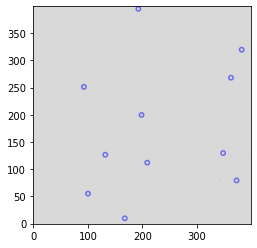

Target expeted location: (199.65, 199.71)
jw01068005001_01101_00001_nrcb1_cal.fits:
Distance between calculated target location and measured target location: 0.815 pixels
Uncertainty in the source location from 2MASS: RA: 0.08", Dec: 0.06", Total: 0.1"
                                             = RA: 2.61 pix, Dec: 1.96 pix, Total: 3.27 pix


108 sources found.


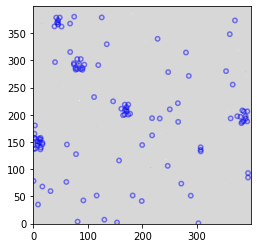

Target expeted location: (280.88, 314.60)
jw01068005001_01101_00002_nrcb5_cal.fits:
Distance between calculated target location and measured target location: 0.337 pixels
Uncertainty in the source location from 2MASS: RA: 0.08", Dec: 0.06", Total: 0.1"
                                             = RA: 1.28 pix, Dec: 0.96 pix, Total: 1.60 pix


1 sources found.


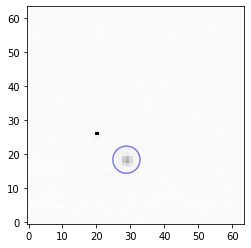

Target expeted location: (29.64, 18.18)
jw01068006001_01101_00001_nrcb1_cal.fits:
Distance between calculated target location and measured target location: 0.846 pixels
Uncertainty in the source location from 2MASS: RA: 0.08", Dec: 0.06", Total: 0.1"
                                             = RA: 2.61 pix, Dec: 1.96 pix, Total: 3.27 pix


2 sources found.


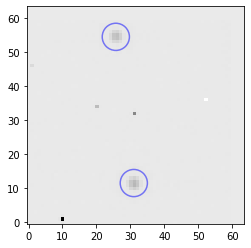

Target expeted location: (26.11, 54.50)
jw01068006001_01101_00002_nrcb5_cal.fits:
Distance between calculated target location and measured target location: 0.412 pixels
Uncertainty in the source location from 2MASS: RA: 0.08", Dec: 0.06", Total: 0.1"
                                             = RA: 1.28 pix, Dec: 0.96 pix, Total: 1.60 pix




In [5]:
for filename in filenames:
    pointing.check_pointing_target_star(filename)

1 2MASS sources should be present on the detector.
11 sources found.


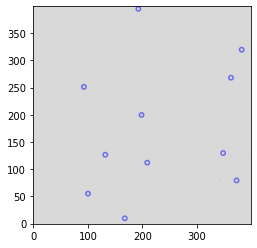

   x       y    image_x image_y delta_pix
------- ------- ------- ------- ---------
201.167 199.726 198.835 199.778     2.285
Median distance between sources in 2MASS catalog and those found in the data: 0.07 arcsec = 2.29 pixels
Mean uncertainty in the source locations within the 2MASS catalog: 0.16 arcsec = 5.13 pixels


7 2MASS sources should be present on the detector.
108 sources found.


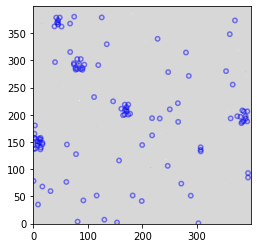

   x       y    image_x image_y delta_pix
------- ------- ------- ------- ---------
281.626 314.610 280.546 314.653     1.065
174.941 210.075 171.189 209.662     3.756
390.270 198.261 390.200 197.296     0.972
308.126 133.484 307.670 132.673     0.925
 85.956 292.996  83.818 293.435     2.164
 45.625 371.556  45.070 369.769     1.861
  6.394 149.789   7.070 150.878     1.310
Median distance between sources in 2MASS catalog and those found in the data: 0.08 arcsec = 1.31 pixels
Mean uncertainty in the source locations within the 2MASS catalog: 0.16 arcsec = 2.52 pixels


1 2MASS sources should be present on the detector.
1 sources found.


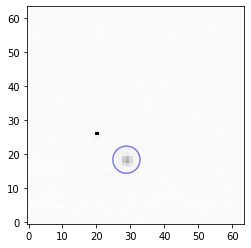

   x       y    image_x image_y delta_pix
------- ------- ------- ------- ---------
 31.163  18.201  28.818  18.376     2.311
Median distance between sources in 2MASS catalog and those found in the data: 0.07 arcsec = 2.31 pixels
Mean uncertainty in the source locations within the 2MASS catalog: 0.16 arcsec = 5.13 pixels


1 2MASS sources should be present on the detector.
2 sources found.


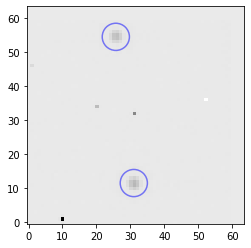

   x       y    image_x image_y delta_pix
------- ------- ------- ------- ---------
 26.852  54.511  25.694  54.528     1.146
Median distance between sources in 2MASS catalog and those found in the data: 0.07 arcsec = 1.15 pixels
Mean uncertainty in the source locations within the 2MASS catalog: 0.16 arcsec = 2.52 pixels




In [6]:
for filename in filenames:
    pointing.check_pointing_using_2mass_catalog(filename)

In [ ]:
Still need SUBTRIPE256

<a id='goal_4'></a>
## Goal 4: Charge Accumulation Rate

Show that the charge accumulation rate in the subarray files is consistent with that in the full frame data

First, check LW data using calibrated slope images

In [2]:
fullframe_file = 'Pipeline_Level2/jw01068004001_01101_00001_nrcb5_cal.fits'

In [3]:
subfiles = sorted(glob('Pipeline_Level2/jw01068001*nrcb5_cal.fits'))
print('subfiles:', subfiles)

subfiles: ['Pipeline_Level2/jw01068001001_01101_00001_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00002_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00003_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00004_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00005_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00006_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00007_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00008_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00009_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00010_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00011_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00012_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00013_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00014_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00015_nrcb5_cal.fits', 'Pipeline_Level2/jw01068001001_01101_00016_nrcb5_cal.fits']


Trying: Pipeline_Level2/jw01068001001_01101_00001_nrcb5_cal.fits
6 sources found.


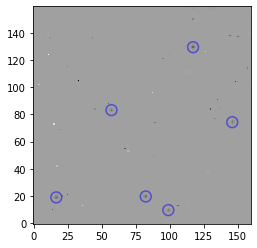

Plot saved to jw01068001001_01101_00001_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


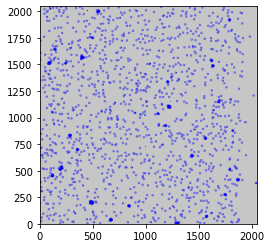

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 6 matching sources.
Performing photometry on a total of 6 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
   98.933     9.570     926.821     878.932 ... 2793.166   -6.746  False   False
   16.472    18.934     844.449     888.242 ... 4395.590   -4.833  False   False
   82.320    19.615     910.219     888.956 ... 4246.650   -6.073   True   False
  145.974    74.268     973.761     943.575 ... 2846.009   -5.395  False   False
   57.104    83.160     884.985     952.409 ... 3110.351   -6.022  False   False
  117.134   129.459     944.912     998.684 ... 5628.755   -8.415   True   False

Trying: Pipeline_Level2/jw01068001001_01101_00002_nrcb5_cal.fits
6 sources found.


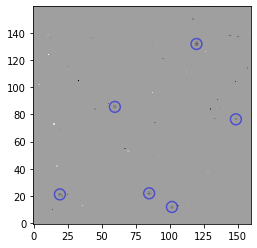

Plot saved to jw01068001001_01101_00002_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


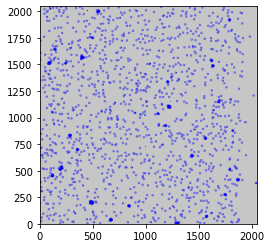

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 6 matching sources.
Performing photometry on a total of 6 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
  101.598    11.896     926.943     878.985 ... 2795.496   -6.381  False   False
   19.129    21.134     844.567     888.168 ... 4395.943  -17.607   True   False
   84.808    21.928     910.166     888.995 ... 4245.918   -4.744   True   False
  148.647    76.381     973.889     943.414 ... 2844.443   -5.070  False   False
   59.594    85.525     884.931     952.497 ... 3110.206   -5.164  False   False
  119.627   131.818     944.860     998.766 ... 5630.842   -6.159   True   False

Trying: Pipeline_Level2/jw01068001001_01101_00003_nrcb5_cal.fits
6 sources found.


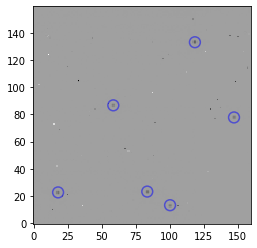

Plot saved to jw01068001001_01101_00003_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


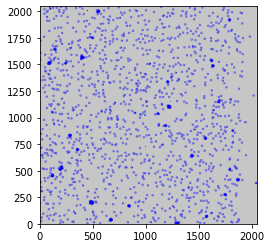

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 6 matching sources.
Performing photometry on a total of 6 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
  100.211    13.184     926.828     879.006 ... 2794.397   -6.140   True   False
   17.812    22.603     844.522     888.371 ... 4398.918   -5.824   True   False
   83.428    23.215     910.057     889.015 ... 4244.337   -6.372   True   False
  147.255    77.764     973.768     943.527 ... 2845.268   -5.659  False   False
   58.436    86.674     885.047     952.379 ... 3111.216   -5.420   True   False
  118.483   133.101     944.988     998.780 ... 5633.073   -7.421   True   False

Trying: Pipeline_Level2/jw01068001001_01101_00004_nrcb5_cal.fits
6 sources found.


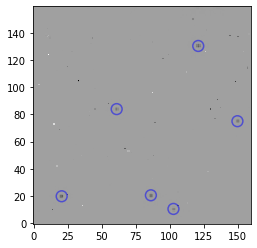

Plot saved to jw01068001001_01101_00004_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


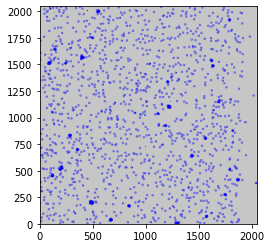

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 6 matching sources.
Performing photometry on a total of 6 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
  102.704    10.444     926.779     879.053 ... 2794.530   -6.743   True   False
   20.449    19.767     844.614     888.319 ... 4399.498  -18.885   True   False
   86.100    20.486     910.186     889.073 ... 4247.369   -4.250   True   False
  149.783    74.999     973.753     943.553 ... 2845.694   -5.726  False   False
   60.920    83.907     884.985     952.400 ... 3110.329   -4.905  False   False
  120.947   130.357     944.906     998.827 ... 5633.390   -6.037  False   False

Trying: Pipeline_Level2/jw01068001001_01101_00005_nrcb5_cal.fits
11 sources found.


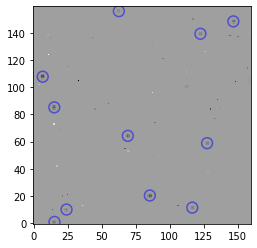

Plot saved to jw01068001001_01101_00005_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


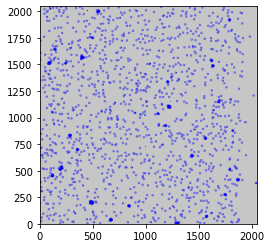

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 11 matching sources.
Performing photometry on a total of 11 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
   15.153     0.883     713.646     741.121 ... 2855.916   -1.287  False   False
   24.010     9.991     722.452     750.204 ... 3079.551   -3.621  False   False
  116.550    11.401     814.672     751.727 ... 2632.286   -2.065   True   False
   85.331    20.314     783.538     760.565 ... 6673.813   -5.518   True   False
  127.444    58.824     825.431     798.988 ... 2772.092   -6.306   True   False
   69.136    64.214     767.307     804.281 ... 5219.909   -4.622  False   False
   15.012    85.175     713.325     825.096 ... 5897.712   -3.466  False   False
    6.508   107.748     704.803     847.575 ... 8510.115   -6.424   True   False
  122.527   139.328     820.366

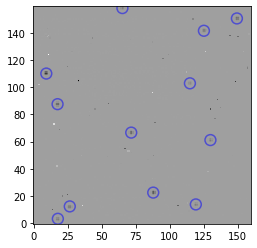

Plot saved to jw01068001001_01101_00006_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


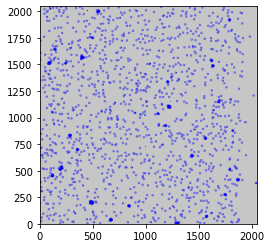

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 12 matching sources.
Performing photometry on a total of 12 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
   17.636     3.185     713.590     741.148 ... 2855.871   -7.552  False   False
   26.420    12.301     722.323     750.239 ... 3077.388   -4.148  False   False
  119.163    13.757     814.741     751.809 ... 2633.337   -3.994   True   False
   87.826    22.453     783.492     760.431 ... 6669.525   -7.249  False    True
  129.920    61.115     825.362     799.004 ... 2771.160   -7.275   True   False
   71.632    66.605     767.260     804.396 ... 5219.289   -5.520  False   False
   17.427    87.536     713.199     825.178 ... 5894.324   -3.860   True   False
  114.822   102.868     810.228     840.584 ... 1565.504   -3.657  False   False
    9.141   110.053     704.895

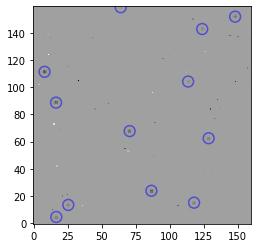

Plot saved to jw01068001001_01101_00007_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


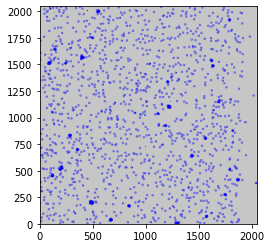

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 12 matching sources.
Performing photometry on a total of 12 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
   16.503     4.510     713.728     741.207 ... 2857.818  -10.029  False   False
   25.309    13.384     722.484     750.058 ... 3077.912   -5.518  False   False
  117.880    15.055     814.728     751.839 ... 2633.605   -6.024   True   False
   86.472    23.806     783.410     760.517 ... 6667.425   -7.503  False   False
  128.600    62.462     825.314     799.082 ... 2771.286   -6.336   True   False
   70.474    67.719     767.374     804.243 ... 5222.980   -6.119  False   False
   16.298    88.665     713.343     825.042 ... 5897.157   -4.553   True   False
  113.500   104.183     810.179     840.631 ... 1565.223   -7.542  False   False
    7.853   111.353     704.881

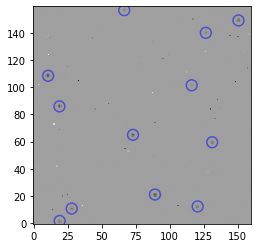

Plot saved to jw01068001001_01101_00008_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


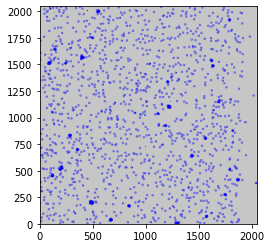

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 12 matching sources.
Performing photometry on a total of 12 sources.
xcentroid ycentroid fullframe_x fullframe_y ... ff_phot  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- -------- ------ -------
   18.953     1.596     713.635     741.077 ... 2854.863   -8.572  False   False
   27.819    10.722     722.449     750.179 ... 3079.031   -4.934  False   False
  120.519    12.290     814.826     751.862 ... 2634.513   -4.493  False   False
   89.099    21.046     783.494     760.544 ... 6671.817   -5.986  False   False
  131.214    59.493     825.386     798.904 ... 2770.469   -4.528   True   False
   72.940    64.956     767.296     804.268 ... 5219.177   -4.736  False   False
   18.799    85.914     713.298     825.077 ... 5895.977   -5.226   True   False
  116.123   101.435     810.257     840.672 ... 1566.708   -5.541  False   False
   10.486   108.420     704.966

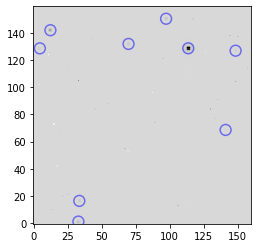

Plot saved to jw01068001001_01101_00009_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


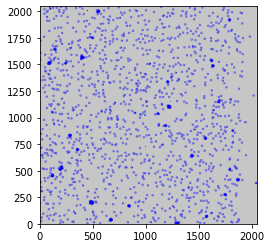

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 8 matching sources.
Performing photometry on a total of 9 sources.
xcentroid ycentroid fullframe_x fullframe_y ... d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- ------ -------
   32.746     1.134     730.462     999.815 ...   -5.242  False   False
   33.432    16.350     731.106    1015.032 ...   -8.452  False   False
  141.091    68.575     838.590    1067.517 ...   -3.907   True   False
  148.432   126.867     845.772    1125.828 ...   -6.652   True   False
    4.399   128.594     701.783    1127.198 ...   -7.048   True   False
  113.597   128.653     810.940    1127.528 ... -675.542   True   False
   69.637   131.854     766.985    1130.620 ...   -7.286  False   False
   12.158   141.950     709.502    1140.572 ...   -7.853   True   False
   97.291   150.385     794.581    1149.219 ...   -5.297  False   False

Trying: Pipeline_Level2/jw01068001001_01101_00010_

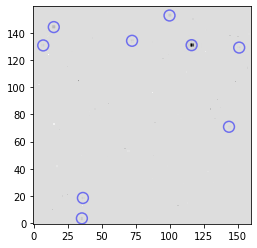

Plot saved to jw01068001001_01101_00010_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


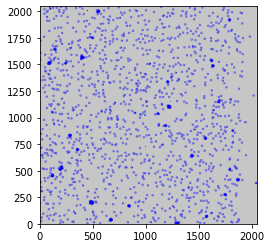

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 8 matching sources.
Performing photometry on a total of 9 sources.
xcentroid ycentroid fullframe_x fullframe_y ... d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- ------ -------
   35.328     3.482     730.504     999.889 ...   -7.441   True   False
   36.074    18.520     731.208    1014.927 ...   -7.932   True   False
  143.576    70.890     838.529    1067.558 ...   -4.339  False   False
  151.079   129.174     845.872    1125.858 ...   -5.199   True   False
    6.877   130.751     701.719    1127.075 ...   -7.058  False   False
  116.058   130.956     810.855    1127.553 ... -687.673   True   False
   72.234   134.158     767.038    1130.646 ...   -7.925  False   False
   14.648   144.255     709.450    1140.597 ...   -6.611  False   False
   99.806   152.771     794.550    1149.326 ...   -6.916   True   False

Trying: Pipeline_Level2/jw01068001001_01101_00011_

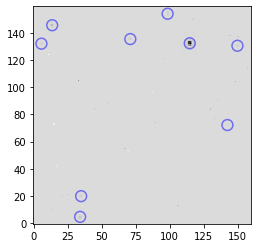

Plot saved to jw01068001001_01101_00011_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


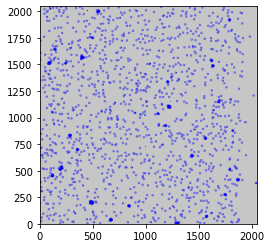

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 8 matching sources.
Performing photometry on a total of 9 sources.
xcentroid ycentroid fullframe_x fullframe_y ... d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- ------ -------
   34.033     4.617     730.481     999.758 ...   -7.704   True   False
   34.785    19.851     731.190    1014.992 ...   -7.634   True   False
  142.426    72.183     838.651    1067.582 ...   -3.274   True   False
  149.787   130.516     845.852    1125.932 ...   -5.401  False   False
    5.550   132.045     701.666    1127.102 ...   -7.397  False   False
  114.680   132.340     810.750    1127.668 ... -676.226   True   False
   70.960   135.436     767.038    1130.656 ...   -9.454  False   False
   13.481   145.628     709.557    1140.703 ...   -6.797   True   False
   98.401   154.052     794.418    1149.338 ...   -6.275   True   False

Trying: Pipeline_Level2/jw01068001001_01101_00012_

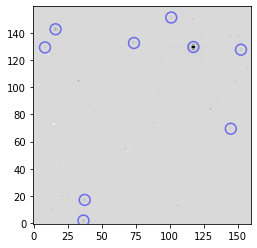

Plot saved to jw01068001001_01101_00012_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


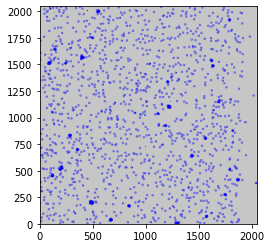

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 8 matching sources.
Performing photometry on a total of 9 sources.
xcentroid ycentroid fullframe_x fullframe_y ... d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- ------ -------
   36.491     1.876     730.396     999.801 ...   -6.352  False   False
   37.397    17.080     731.259    1015.006 ...   -6.480   True   False
  144.894    69.441     838.575    1067.630 ...   -4.218  False   False
  152.390   127.613     845.910    1125.821 ...    0.578   True   False
    8.174   129.268     701.741    1127.112 ...   -6.368  False   False
  117.375   129.596     810.898    1127.715 ... -681.220   True   False
   73.648   132.531     767.178    1130.540 ...   -7.665  False   False
   15.950   142.679     709.477    1140.541 ...   -6.193  False   False
  101.074   151.303     794.543    1149.380 ...   -5.633  False   False

Trying: Pipeline_Level2/jw01068001001_01101_00013_

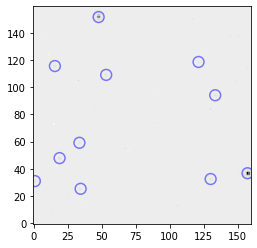

Plot saved to jw01068001001_01101_00013_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


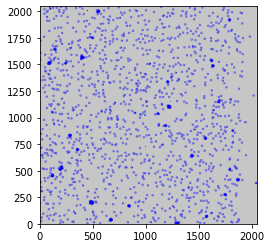

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 9 matching sources.
Performing photometry on a total of 11 sources.
xcentroid ycentroid fullframe_x fullframe_y ...  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... --------- ------ -------
   34.411    25.250     992.396    1023.908 ...    -4.582  False   False
    0.712    30.917     958.668    1029.593 ...    -0.994  False    True
  130.067    32.444    1088.142    1031.074 ...   -16.533   True   False
  157.205    36.715    1115.307    1035.338 ... -1148.534   True   False
   18.911    47.836     976.893    1046.524 ...    -6.715  False   False
   33.511    59.107     991.512    1057.800 ...    -6.005   True   False
  133.426    94.092    1091.533    1092.782 ...    -8.932   True    True
   53.204   109.074    1011.247    1107.810 ...    -5.998   True   False
   15.458   115.583     973.470    1114.339 ...    -5.075   True   False
  121.172   118.581    1079.280    1117

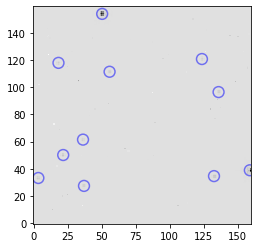

Plot saved to jw01068001001_01101_00014_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


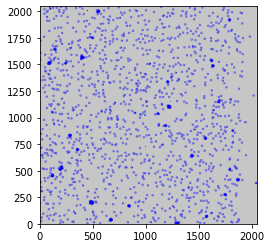

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 9 matching sources.
Performing photometry on a total of 11 sources.
xcentroid ycentroid fullframe_x fullframe_y ... d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- ------ -------
   36.878    27.382     992.322    1023.766 ...   -5.106   True   False
    3.289    33.210     958.705    1029.611 ...   -9.160  False    True
  132.539    34.596    1088.070    1030.953 ...  -16.619   True   False
  158.921    38.898    1114.476    1035.249 ... -302.996   True   False
   21.578    50.111     977.019    1046.522 ...   -7.454  False   False
   36.155    61.441     991.615    1057.858 ...   -6.454   True   False
  135.903    96.436    1091.465    1092.850 ...   -7.197  False   False
   55.700   111.381    1011.200    1107.839 ...   -5.396   True   False
   18.105   117.916     973.575    1114.395 ...   -6.080   True   False
  123.668   120.737    1079.230    1117.179 ...   

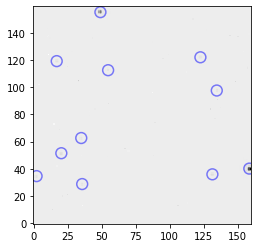

Plot saved to jw01068001001_01101_00015_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


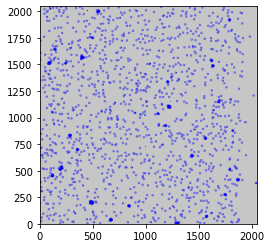

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 9 matching sources.
Performing photometry on a total of 11 sources.
xcentroid ycentroid fullframe_x fullframe_y ...  d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... --------- ------ -------
   35.552    28.736     992.268    1023.854 ...    -5.693  False   False
    1.988    34.590     958.677    1029.726 ...    -8.052  False    True
  131.364    35.905    1088.166    1030.993 ...   -16.068   True   False
  158.521    40.119    1115.347    1035.201 ... -1024.527   True   False
   20.196    51.440     976.909    1046.586 ...    -5.979   True   False
   34.856    62.615     991.588    1057.766 ...    -6.752  False   False
  134.580    97.572    1091.414    1092.718 ...    -7.707  False   False
   54.625   112.525    1011.398    1107.716 ...    -5.355  False   False
   16.805   119.195     973.548    1114.407 ...    -5.672   True   False
  122.541   122.030    1079.376    1117

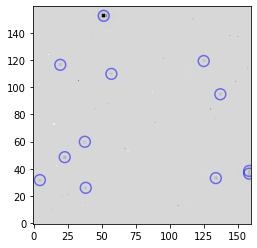

Plot saved to jw01068001001_01101_00016_nrcb5_cal.fits_subarray_source_map_datamodels.png
1557 sources found.


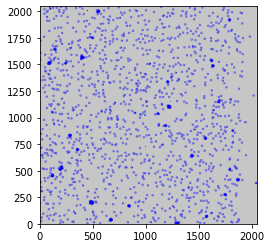

Plot saved to jw01068004001_01101_00001_nrcb5_cal.fits_fullframe_map_datamodels.png
Found 10 matching sources.
Performing photometry on a total of 12 sources.
xcentroid ycentroid fullframe_x fullframe_y ... d_phot_p sub_dq full_dq
--------- --------- ----------- ----------- ... -------- ------ -------
   38.167    25.982     992.339    1023.885 ...   -4.835  False   False
    4.428    31.653     958.572    1029.573 ...   -9.133  False    True
  133.874    33.125    1088.133    1031.003 ...  -16.841   True   False
  158.414    36.423    1112.696    1034.295 ...   13.714   True   False
  158.419    38.389    1112.702    1036.263 ...   13.286  False   False
   22.699    48.538     976.867    1046.469 ...   -7.790  False   False
   37.501    59.858     991.687    1057.795 ...   -5.803  False   False
  137.205    94.829    1091.495    1092.766 ...   -6.058  False   False
   57.016   109.796    1011.242    1107.775 ...   -5.534   True   False
   19.427   116.467     973.623    1114.466 ...  

In [4]:
# sub_dq and full_dq columns: if True, then there is at least one non-zero value
# in the DQ array within the photometry aperture in the subarray or full frame
# images, respectively. In some cases this may not matter. But in some cases the
# flagged pixel defintely has an effect.

# d_phot_p is the percentage difference in the photometry between the subarray
# and full frame cases. Eqn is (full frame - subarray) / full frame, so negative
# means the source is brighter in the subarray data
for subarray_file in subfiles:
    print('Trying: {}'.format(subarray_file))
    count_rates.compare_rate_images(subarray_file, fullframe_file)

Now look at SW data calibrated slope images

In [ ]:
fullframe_file = 'Pipeline_Level2/jw01068004001_01101_00001_nrcb1_cal.fits'

In [ ]:
subfiles = sorted(glob('Pipeline_Level2/jw01068001*nrcb1_cal.fits'))
print('subfiles:', subfiles)

In [ ]:
for subarray_file in subfiles:
    print('Trying: {}'.format(subarray_file))
    count_rates.compare_rate_images(subarray_file, fullframe_file)

Next, compare data in the level 3 output source catalogs

<a id='goal_5'></a>
## Goal 5: Identify and characterize latency

Using _cal.fits files:
1. Locate and do aperture photometry on sources in exposure 1
2. Locate and do aperture photometry on sources in exposure 2
3. In exposure 2, do aperture photometry on locations from exposure 1, excluding locations where there is also a source in exposure 2.
4. Create plot of "empty" location photometry vs time since dither?
5. Repeat for subsequent exposures



Check with Jarron to see what software he has for this

In [ ]:
files = sorted(glob('Pipeline_Level1/jw01068001001*nrcb5_rateints.fits'))

In [ ]:
latency.check(files)